**Business Problem:** I would like to spin up an AWS EMR cluster every weekday at 7AM local time. I have the cluster all configured in a Lambda function and can invoke it in AWS CLI using the below script:

        aws lambda invoke --function-name leedfeed_webforms_emr response.json

The Lambda function creates a EMR cluster with some specific settings:

        import boto3

        def lambda_handler(event, context):
            # Connect to the Amazon EMR API
            client = boto3.client('emr')

            response = client.run_job_flow(
            Name="<REDACTED>_emr_cluster",                # Name of the EMR Cluster.
            LogUri='<REDACTED>',                          # This is the location of the log files.
                                                          # Keep in the <REDACTED> directory as it has a S3 LifeCycle 
                                                          # implemented of 7 days to clear out old files for cost optimization.
            ReleaseLabel='emr-7.0.0',

            Instances={
                'InstanceGroups': [
                    {
                        'Name': 'Master nodes',
                        'Market': 'ON_DEMAND',            # Use SPOT for production jobs.
                        'InstanceRole': 'MASTER',
                        'InstanceType': 'm5.xlarge',
                        'InstanceCount': 1
                    },
                    {
                        'Name': 'Core nodes',
                        'Market': 'ON_DEMAND',            # Use SPOT for production jobs.
                        'InstanceRole': 'CORE',
                        'InstanceType': 'm5.xlarge',
                        'InstanceCount': 2
                    }
                ],
                'Ec2KeyName': '<REDACTED>',
                'AdditionalMasterSecurityGroups':['<REDACTED>'],    # This would be the associated VPC Security Group:
                                                                    # <REDACTED>
                'AdditionalSlaveSecurityGroups':['<REDACTED>'],     # This would be the associated VPC Security Group:
                                                                    # <REDACTED>
                'KeepJobFlowAliveWhenNoSteps':True,                 # False would terminate cluster post-run. Keep True to keep cluster active.
                'TerminationProtected':False,
                'Ec2SubnetId':'<REDACTED>'},                        # This would be the associated VPC Subnet:
                                                                    # <REDACTED>

            Applications=[
                {
                'Name': 'Spark'
                },
                {
                'Name': 'JupyterEnterpriseGateway'
                },
                {
                'Name': 'JupyterHub'
                },
                {
                'Name': 'Trino'
                }
            ], 

            VisibleToAllUsers=False,
            JobFlowRole='<REDACTED>',                     # This is our instance profile which is <REDACTED> for all known instances.
            ServiceRole='<REDACTED>',                     # This is the ARN of the Service Role with EMR permissions. In this case,
                                                          # that would be the <REDACTED> which has the below ARN:
                                                          # <REDACTED>

            AutoTerminationPolicy={
                'IdleTimeout': 43200                      # Calculated in seconds. In this case it would yield 7AM-7PM service hours.
            }
            )

            return {
                'statusCode': 200,
            }

Note: Additional details for the run_job_flow functionality can be found [here](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/emr/client/run_job_flow.html). This function is what enables the ability to create a EMR Cluster.

I want to automate this so that it invokes itself using Amazon EventBridge. How do I do this?

**Solution:**

- In AWS, go to Amazon EventBridge. In the left-hand menu, select Schedules under the Scheduler header.
- Under Schedules, select the *Create schedule* button.
- Input a *Schedule name* and optional *Description*.

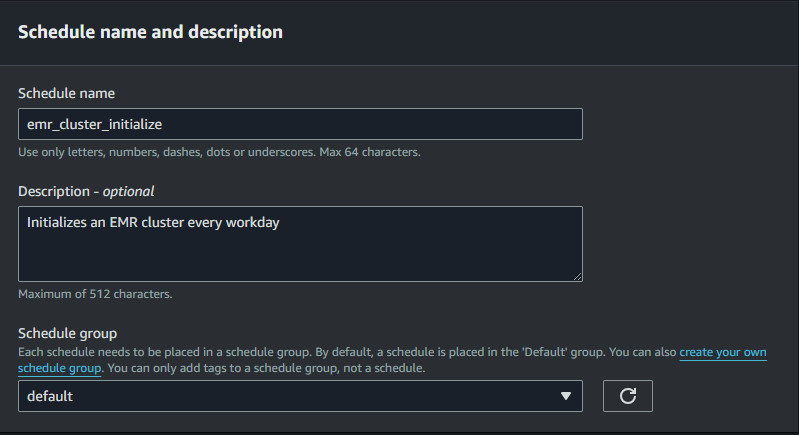

- Select the *Recurring schedule* under the *Schedule pattern* section.
- Enter a *Time zone* and select *Cron-based schedule*.
- Enter the below under the *Cron expression* section for a 7AM MT schedule:

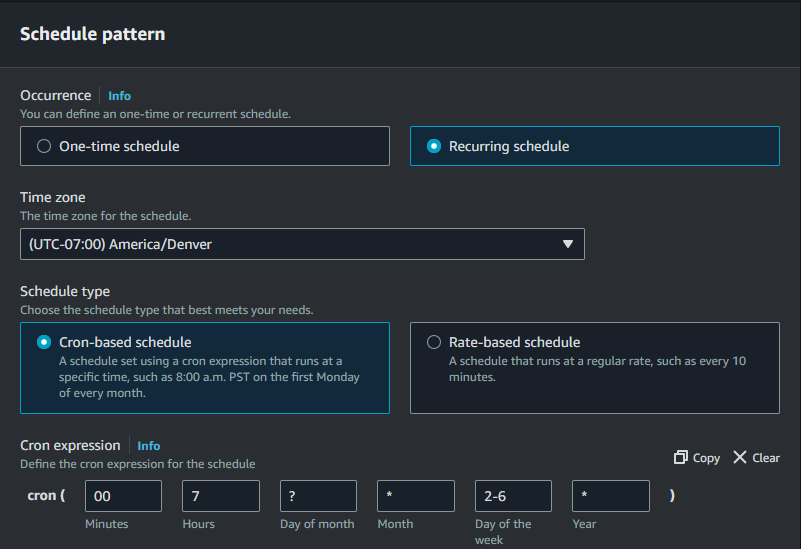

- For further details on how to configure the Cron expression, read through the documentation under *Cron-based schedules* section of this [website](https://docs.aws.amazon.com/scheduler/latest/UserGuide/schedule-types.html?icmpid=docs_console_unmapped#cron-based).

- You will need to select a *Flexible time window* as well.
- You can add a *Timeframe* attribute if you'd like but for this case it is not necessary.
- Note: Amazon EventBridge Scheduler automatically adjust for Daylights saving time.
- Select *Next*.
- In the *Target detail* section, select *Templated targets* and then select the *AWS Lambda Invoke* option.

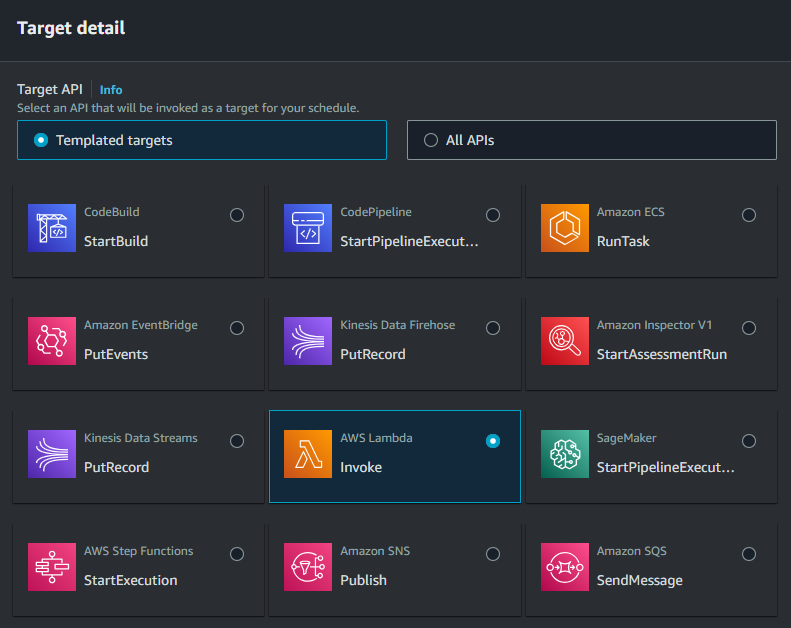

- Under the *Invoke* section, select the target Lambda function and then select *Next*.

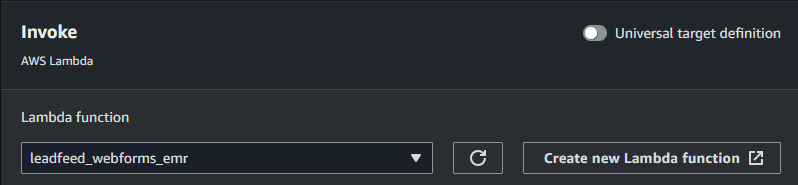

- On the next page, you'll need to assign the *Action after schedule completion* to *NONE*.

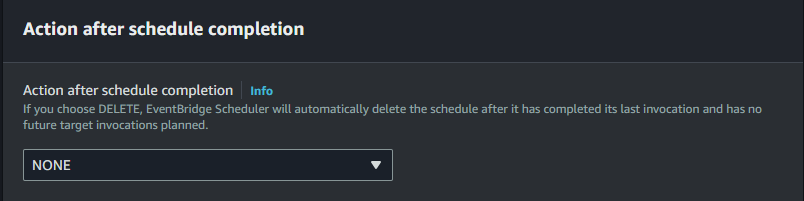

- If you want to define a *Retry policy and dead-letter queue* then configure it here. In my case, set th *Max age of event* to 5 minutes and the *Retry attempts* to 3 times. This means that if it failed to invoke the schedule, that it will retry again in 5 minutes up to 3 times.

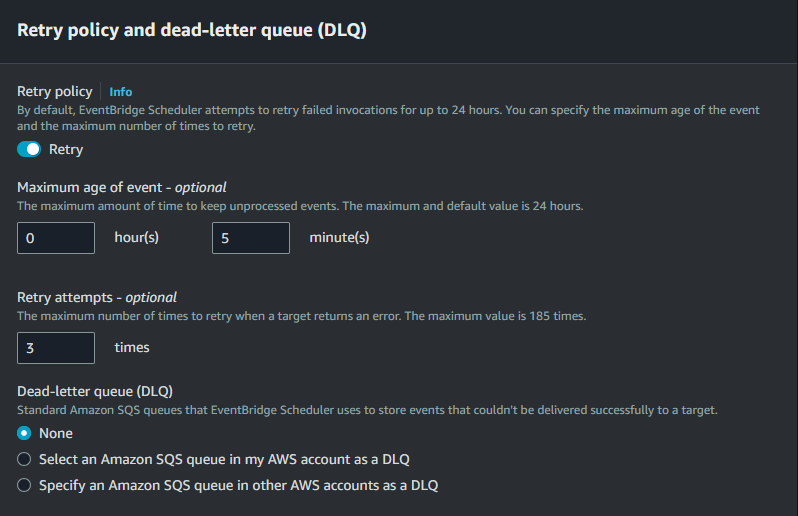

- You will then need to set *Permissions* and in my case, select the *Use existing role* and then select the associated existing role in the drop-down.
- Important notice: You will need make sure that this service role has the proper IAM permissions and will also need to adjust the *Trust relationships* fo include "scheduler.amazonaws.com" for this to work.

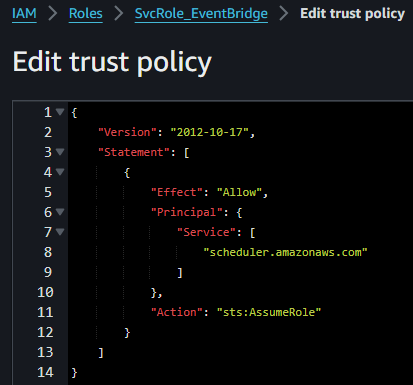

- Select *Next* to go to the confirmation page. Review the details and then select *Create schedule* and it should be up and running. It is recommended to test and ensure that it is working properly.
